In [2]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [43]:
import numpy as np
import cv2
import os

from transformers import ViTImageProcessor, TrainingArguments, ViTForImageClassification, Trainer
import torch 

from string import ascii_uppercase

from tqdm import tqdm

from datasets import Dataset, load_metric, ClassLabel

from PIL import Image

## 1) Carregando imagens

In [5]:
# Definir classes (letras do alfabeto, excluindo H, J, K, X e Z)
classes = [letter for letter in ascii_uppercase if letter not in {'H', 'J', 'K', 'X', 'Z'}]

num_classes = len(np.unique(classes))

print(f'Classes: {classes}')
print(f'Número de classes: {num_classes}')

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
Número de classes: 21


In [68]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in tqdm(os.listdir(label_path), desc=f"Loading {label} images"):
                img_path = os.path.join(label_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".png"):
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

                    # Converter a matriz de volta para a imagem original
                    image = Image.fromarray(img.astype('uint8'))
                    images.append(image)
                    labels.append(label)
                    
    return images, labels

In [69]:
X_train_images, y_train_labels = load_images_from_folder('../libras_dataset/train')
X_test_images, y_test_labels = load_images_from_folder('../libras_dataset/test')

Loading Y images: 100%|██████████| 550/550 [00:00<00:00, 3374.25it/s]


In [70]:
train_data = {"image": X_train_images, "label": y_train_labels}
test_data = {"image": X_test_images, "label": y_test_labels}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset, test_dataset

(Dataset({
     features: ['image', 'label'],
     num_rows: 34714
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 11548
 }))

In [71]:
num_classes = len(set(train_dataset["label"]))
labels = train_dataset.features['label']
num_classes, labels

(21, Value(dtype='string', id=None))

In [49]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>,
 'label': 'A'}

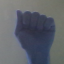

In [77]:
train_dataset[0]['image']

In [78]:
train_dataset[0]['label'] 

# labels.names[train_dataset[0]['label']]

'A'

## 2) Rede com ViT

### 2.1) Modelo vit-base-patch16-224 (https://huggingface.co/google/vit-base-patch16-224) 

In [79]:
model_name_or_path = "google/vit-base-patch16-224"

feature_extractor = ViTImageProcessor .from_pretrained(
    model_name_or_path
)

In [80]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [81]:
example = feature_extractor(
    train_dataset['image'][0],
    return_tensors="pt"
)

example

{'pixel_values': tensor([[[[ 0.1216,  0.1216,  0.1216,  ..., -0.1529, -0.1529, -0.1529],
          [ 0.1216,  0.1216,  0.1216,  ..., -0.1529, -0.1529, -0.1529],
          [ 0.1216,  0.1216,  0.1216,  ..., -0.1529, -0.1529, -0.1529],
          ...,
          [-0.0196, -0.0196, -0.0196,  ..., -0.2235, -0.2235, -0.2235],
          [-0.0196, -0.0196, -0.0196,  ..., -0.2235, -0.2235, -0.2235],
          [-0.0196, -0.0196, -0.0196,  ..., -0.2235, -0.2235, -0.2235]],

         [[ 0.1137,  0.1137,  0.1137,  ..., -0.1216, -0.1216, -0.1216],
          [ 0.1137,  0.1137,  0.1137,  ..., -0.1216, -0.1216, -0.1216],
          [ 0.1137,  0.1137,  0.1137,  ..., -0.1216, -0.1216, -0.1216],
          ...,
          [ 0.0039,  0.0039,  0.0039,  ..., -0.1608, -0.1608, -0.1608],
          [ 0.0039,  0.0039,  0.0039,  ..., -0.1608, -0.1608, -0.1608],
          [ 0.0039,  0.0039,  0.0039,  ..., -0.1608, -0.1608, -0.1608]],

         [[ 0.0824,  0.0824,  0.0824,  ..., -0.2000, -0.2000, -0.2000],
          [ 0

In [56]:
print("Shape da Imagem original: ", train_dataset['image'][0].size, "\n")

print("Shape da Imagem com resize do pytorch: ", example['pixel_values'].shape)	 

Shape da Imagem original:  (64, 64) 

Shape da Imagem com resize do pytorch:  torch.Size([1, 3, 224, 224])


In [57]:
print(torch.cuda.is_available())

False


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cpu')

## 3) Fine-tuning do modelo

In [59]:
def preprocess(batch): 
    inputs = feature_extractor(
        batch['image'], 
        return_tensors="pt"
    )

    inputs['label'] = batch['label']

    return inputs 

### 3.1) Adquirindo batchs de dados

In [60]:
prepared_train = train_dataset.with_transform(preprocess)
prepared_test = test_dataset.with_transform(preprocess)

In [61]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [84]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=p.predictions.argmax(axis=1),
        references=p.label_ids
    )

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### 3.2) Argumentos do treinamento

In [63]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    # logging_dir="./logs",
    # do_train=True,
    # do_eval=True,
    # metric_for_best_model="accuracy"
)

### 3.3) Adquirindo modelo pré-treinado

In [64]:
labels = classes

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([21]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([21, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### 3.4) Preparando o modelo pré-treinado para um novo treinamento

In [66]:
trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_train,
        eval_dataset=prepared_test,
        tokenizer=feature_extractor
    )

### 3.5) Novo Treinamento do modelo pré-treinado

In [67]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train.json", train_results.metrics)
trainer.save_metrics("train.json", train_results.metrics)

trainer.save_state()

  0%|          | 0/8680 [00:00<?, ?it/s]

ValueError: too many dimensions 'str'

### 3.6) Testando modelo 

In [ ]:
metrics = trainer.evaluate(prepared_test)

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

### 3.7) Visualizando predição com uma imagem especifica do conjunto de teste

In [ ]:
image = test_dataset['image'][0].resize((224, 224))
image

NameError: name 'test_dataset' is not defined

In [ ]:
actual_label = test_dataset['label'][0]
labels = test_dataset.features['label']

actual_label, labels.names[actual_label]

In [ ]:
trainer.predict(image)

# with torch.no_grad():
#     logits = model(**inputs).logits